In [1]:
# 从sklearn 调入所需要的包
# from sklearn import datasets

import os
import json
import gc
# os.system('pip install numba')
from numba import jit
#tqdm
# os.system('pip install tqdm')
from tqdm import tqdm_notebook
from tqdm import tqdm

#Integrated model
# os.system('pip install lightgbm')
import lightgbm as lgb
# os.system('pip install catboost==0.15.2')
import catboost as cbt
# os.system('pip install xgboost')
# import xgboost as xgb

#base import 
import numpy as np
import pandas as pd

# about sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as std
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import f1_score
#about time
import time
import datetime 
from datetime import datetime, timedelta

#Garbage collection
import gc
# scipy
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import scipy.spatial.distance as dist
#other
from collections import Counter 
from statistics import mode 
    #warning
import warnings
warnings.filterwarnings("ignore")
import json 
import math
from itertools import product
import ast
from sklearn.model_selection import train_test_split #数据分隔出训练集和验证集
import lightgbm as lgb
import numpy as np 
import pandas as pd
#导入精度和召回
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
pd.set_option('display.max_columns',None)

In [2]:
path = "./ccf_data/"

In [3]:
train = pd.read_csv(path + "train_2.csv")
test = pd.read_csv(path + "test_2.csv")

In [4]:
train_first = pd.read_csv(path + "train_all.csv")

In [5]:
train.head()

,service_type,is_mix_service,online_time,1_total_fee,2_total_fee,3_total_fee,4_total_fee,month_traffic,many_over_bill,contract_type,contract_time,is_promise_low_consume,net_service,pay_times,pay_num,last_month_traffic,local_trafffic_month,local_caller_time,service1_caller_time,service2_caller_time,gender,age,complaint_level,former_complaint_num,former_complaint_fee,current_service,user_id
0,1,0,18,50.4,108.2,118.9,177.7,300.0,1,0,0,0,4,2,60.0,0.0,2639.084859,37.783333,37.783333,0.0,1,19,0,0,0,90063345,012pSke7DsCrR985
1,1,0,16,84.4,78.2,56.9,80.4,0.0,1,0,0,0,4,3,90.0,0.0,39155.458728,5.183333,41.833333,0.0,1,20,0,0,0,90063345,012re3ZJSB6FptHW
2,1,0,9,80.5,75.6,74.3,93.4,0.0,1,0,0,0,4,4,70.0,0.0,48755.950069,63.866667,67.666667,0.0,1,18,0,0,0,90063345,013ElTBrRntuZDXz
3,1,0,15,69.3,63.8,50.2,62.2,0.0,1,0,0,0,4,2,60.0,0.0,0.000000,5.750000,11.483333,0.0,1,29,0,0,0,90063345,0146B9qQbNxIynoX
4,1,0,18,37.3,33.2,19.8,19.5,0.0,1,0,0,0,4,1,20.0,0.0,5257.352050,4.050000,4.383333,0.0,1,24,0,0,0,90063345,0149vWf6u8UrKyJT


复赛数据集中的999999套餐只有两个人在使用   
初赛套餐种类没有999999

In [6]:
train.current_service.value_counts()

90063345    217513
89950167     39307
89950166     26420
90109916     18299
99999828     17164
90155946     13147
99999830     11546
99999826      9279
99999827      8526
89950168      7374
99999825      6078
999999           2
Name: current_service, dtype: int64

In [7]:
train_first.current_service.value_counts()

90063345    287219
89950166    133224
89950167     73842
99999828     52939
90109916     38096
89950168     33462
99999827     32531
99999826     29054
90155946     22037
99999830     21236
99999825     20350
Name: current_service, dtype: int64

In [8]:
train_first.describe()

,service_type,is_mix_service,online_time,1_total_fee,4_total_fee,month_traffic,many_over_bill,contract_type,contract_time,is_promise_low_consume,net_service,pay_times,pay_num,last_month_traffic,local_trafffic_month,local_caller_time,service1_caller_time,service2_caller_time,complaint_level,former_complaint_num,former_complaint_fee,current_service
count,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,743990.000000,7.439900e+05,7.439900e+05
mean,2.599368,0.041987,42.163250,105.316648,110.909542,1280.314131,0.471436,1.733792,7.769703,0.069266,3.934737,1.962678,124.645043,361.884730,6374.492367,63.181143,44.942956,96.227216,0.115961,0.134366,4.117919e+06,9.211684e+07
std,1.496706,0.200560,45.526346,90.661524,102.790653,2865.051949,0.499184,3.145238,10.348774,0.253906,0.329559,1.535140,222.082875,821.310454,11871.581287,121.448525,113.855830,144.503062,0.375613,0.473779,2.539640e+09,4.062611e+06
min,1.000000,0.000000,1.000000,0.000000,-420.270000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.995017e+07
25%,1.000000,0.000000,10.000000,52.200000,51.600000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,50.000000,0.000000,136.277616,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.995017e+07
50%,4.000000,0.000000,17.000000,76.000000,78.400000,300.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,90.000000,0.000000,1455.823977,15.016667,0.000000,39.058333,0.000000,0.000000,0.000000e+00,9.006334e+07
75%,4.000000,0.000000,65.000000,127.450000,137.000000,1535.362151,1.000000,3.000000,12.000000,0.000000,4.000000,2.000000,150.000000,493.497146,5919.948412,74.483333,38.850000,145.650000,0.000000,0.000000,0.000000e+00,9.010992e+07
max,4.000000,1.000000,274.000000,5940.830000,5141.270000,159057.397800,1.000000,12.000000,52.000000,1.000000,9.000000,127.000000,58800.300000,17408.000000,484365.746313,6461.050000,5139.483333,16454.383333,3.000000,22.000000,1.762166e+12,9.999983e+07


In [9]:
train.describe()

,service_type,is_mix_service,online_time,1_total_fee,4_total_fee,month_traffic,many_over_bill,contract_type,contract_time,is_promise_low_consume,net_service,pay_times,pay_num,last_month_traffic,local_trafffic_month,local_caller_time,service1_caller_time,service2_caller_time,gender,age,complaint_level,former_complaint_num,former_complaint_fee,current_service
count,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,3.746550e+05
mean,2.006395,0.076102,30.818812,85.699761,88.725655,845.024251,0.624273,1.034202,5.655035,0.040640,3.966425,2.098782,113.938214,236.159435,8701.387218,63.488639,43.732007,70.755817,1.286047,29.886242,0.115141,0.108401,234.727101,9.144117e+07
std,1.416391,0.265162,34.206022,67.550817,81.935385,2405.029450,0.484311,2.727514,10.278684,0.197455,0.250825,1.803206,326.550637,616.192328,14285.552230,137.181220,98.386049,152.190236,0.469229,10.771338,0.411072,0.418075,3113.607863,3.465090e+06
min,1.000000,0.000000,2.000000,0.000000,-14.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.999990e+05
25%,1.000000,0.000000,9.000000,49.500000,46.100000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,50.000000,0.000000,22.091886,0.000000,0.000000,0.000000,1.000000,22.000000,0.000000,0.000000,0.000000,9.006334e+07
50%,1.000000,0.000000,15.000000,68.660000,66.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,2.000000,80.000000,0.000000,2094.756654,14.650000,2.166667,2.533333,1.000000,28.000000,0.000000,0.000000,0.000000,9.006334e+07
75%,4.000000,0.000000,46.000000,99.300000,106.000000,782.912493,1.000000,1.000000,12.000000,0.000000,4.000000,3.000000,100.000000,0.000000,10947.530049,74.633333,47.150000,89.966667,2.000000,35.000000,0.000000,0.000000,0.000000,9.006334e+07
max,4.000000,1.000000,272.000000,3392.000000,2359.750000,238395.390250,1.000000,12.000000,52.000000,1.000000,9.000000,219.000000,153550.210000,12286.330195,386005.659265,16569.416667,5093.133333,16591.250000,2.000000,103.000000,3.000000,20.000000,410935.000000,9.999983e+07


查看特征直接的相关性

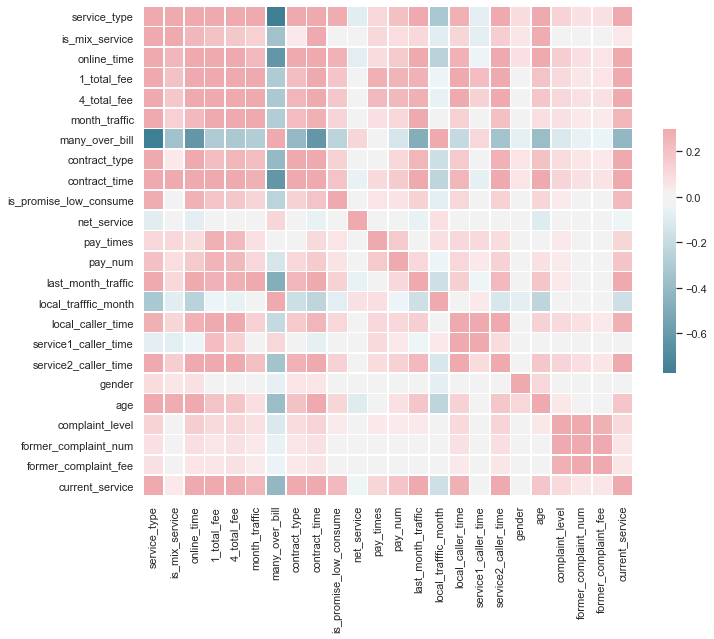

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="white")
# 计算训练集的相关性
corr = train.corr()
# 设置 matplotlib f的尺寸
f, ax = plt.subplots(figsize=(11, 9))
# 生成自定义的散色图
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# 为热力图设置长宽比
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [11]:
# 训练集和测试集形状
train.shape, test.shape

((374655, 27), (160566, 26))

In [12]:
# 无Nan值
train.isnull().sum()

service_type              0
is_mix_service            0
online_time               0
1_total_fee               0
2_total_fee               0
3_total_fee               0
4_total_fee               0
month_traffic             0
many_over_bill            0
contract_type             0
contract_time             0
is_promise_low_consume    0
net_service               0
pay_times                 0
pay_num                   0
last_month_traffic        0
local_trafffic_month      0
local_caller_time         0
service1_caller_time      0
service2_caller_time      0
gender                    0
age                       0
complaint_level           0
former_complaint_num      0
former_complaint_fee      0
current_service           0
user_id                   0
dtype: int64

In [13]:
train_first.isnull().sum()

service_type              0
is_mix_service            0
online_time               0
1_total_fee               0
2_total_fee               0
3_total_fee               0
4_total_fee               0
month_traffic             0
many_over_bill            0
contract_type             0
contract_time             0
is_promise_low_consume    0
net_service               0
pay_times                 0
pay_num                   0
last_month_traffic        0
local_trafffic_month      0
local_caller_time         0
service1_caller_time      0
service2_caller_time      0
gender                    0
age                       0
complaint_level           0
former_complaint_num      0
former_complaint_fee      0
current_service           0
user_id                   0
dtype: int64

In [ ]:
f,ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation="90")
sns.barplot(x=train_first["service_type"].index, y=train_first["service_type"])
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing values", fontsize=15)
plt.title("Percent missing data by feature", fontsize=15)